In [11]:
# Install the libraries in case the system you're working on does not have them installed already
# pip install numpy matplotlib scikit-learn pydotplus ipython

### Import the libraries

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, log_loss

### General function to plot neural network's decision boundary

In [129]:
def plot_decision_boundary(model, X, y, title="Decision Boundary", resolution=100):
    # Create a mesh grid based on the range of the data
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution), np.linspace(y_min, y_max, resolution))
    
    # Predict over the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary using contour plot
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    
    # Plot the data points with different markers for each class
    for class_value in np.unique(y):
        row_ix = np.where(y == class_value)
        if class_value == 0:
            marker = 'o'  # Circle marker for class 0
            edge_color = 'k'
            face_color = 'blue'
        else:
            marker = 'x'  # Cross marker for class 1
            edge_color = 'k'
            face_color = 'red'
        plt.scatter(X[row_ix, 0], X[row_ix, 1], c=face_color, edgecolors=edge_color, marker=marker, label=f'Class {class_value}')
    
    # Add titles and labels
    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(loc='upper right')
    
    # Show plot
    plt.show()

### Z-Formula Function

In [130]:
def detect_z_formula(X, Z):
    if np.allclose(Z, X[:, 0]**2 + X[:, 1]**2):
        z_type = 'circular'
        z_formula = "X1**2 + X2**2"
    elif np.allclose(Z, X[:, 0]**2 / 0.7**2 + X[:, 1]**2 / 0.5**2):
        z_type = 'elliptical'
        z_formula = "X1**2/a**2 + X2**2/b**2"
    elif np.allclose(Z, X[:, 0] + X[:, 1]):
        z_type = 'linear'
        z_formula = "X1 + X2"
    elif np.allclose(Z, np.maximum(np.abs(X[:, 0]), np.abs(X[:, 1]))):
        z_type = 'square'
        z_formula = "max(abs(X1), abs(X2))"
    elif np.allclose(Z, X[:, 0]):
        z_type = 'lin'
        z_formula = "X1"
    else:
        z_type = 'unknown'
        z_formula = "custom_Z"
    
    return z_type, z_formula

### Function to derive boolean condition from the decision tree

In [131]:
feature_names = ['X1', 'X2', 'Z']
classes = ['Blue', 'Red']

In [132]:
# Implement and evaluate the boolean condition
def get_decision_tree_condition(tree_model, X, z, feature_names, classes):
    # Detect Z formula type and string representation
    z_type, z_formula = detect_z_formula(X, z)
    
    tree = tree_model.tree_
    feature_index = tree.feature[0]
    threshold = tree.threshold[0]
    
    left_class = classes[np.argmax(tree.value[tree.children_left][0])]
    right_class = classes[np.argmax(tree.value[tree.children_right][0])]
    
    # Generate condition string dynamically based on detected Z formula
    if feature_index == 2:
        condition = f"IF {z_formula} <= {threshold:.3f} ? {left_class} : {right_class}"
    else:
        condition = f"IF {feature_names[feature_index]} <= {threshold:.3f} ? {left_class} : {right_class}"

    boolean_condition = lambda X: np.where(X[:, feature_index] <= threshold, left_class, right_class)
    
    return condition, boolean_condition

### Function to visualise decision tree

In [133]:
def create_dtree(tree_model):
    dot_data = export_graphviz(tree_model, 
                               filled=True, 
                               rounded=True, 
                               class_names=['Blue', 'Red'],
                               feature_names=['X1', 'X2', 'Z'],
                               out_file=None)
    graph = graph_from_dot_data(dot_data)
    
    # Modify the node colors based on class
    for node in graph.get_nodes():
        if node.get_label():
            if 'class = Blue' in node.get_label():
                node.set_fillcolor("#add8e6")
            elif 'class = Red' in node.get_label():
                node.set_fillcolor("#ffcccc")

    # Create the PNG image from graph
    image = graph.create_png()
    return Image(image)

In [134]:
def create_dtree_without_z(tree_model):
    dot_data = export_graphviz(tree_model, 
                               filled=True, 
                               rounded=True, 
                               class_names=['Blue', 'Red'],
                               feature_names=['X1', 'X2'],
                               out_file=None)
    graph = graph_from_dot_data(dot_data)

    # Modify the node colors based on class
    for node in graph.get_nodes():
        if node.get_label():
            if 'class = Blue' in node.get_label():
                node.set_fillcolor("#add8e6")
            elif 'class = Red' in node.get_label():
                node.set_fillcolor("#ffcccc")

    # Create the PNG image from graph
    image = graph.create_png()
    return Image(image)

### Function to apply the decision boundary equation on the input data to check its accuracy

In [135]:
# Function to apply the equation
def apply_decision_tree_equation(X, feature_index, threshold):
    return np.where(X[:, feature_index] <= threshold, 0, 1)  # 0 and 1 are class labels

# Evaluate equation accuracy
def evaluate_equation_accuracy(X_combined, y_true, feature_index, threshold):
    y_pred = apply_decision_tree_equation(X_combined, feature_index, threshold)
    accuracy = np.mean(y_pred == y_true)
    return accuracy

## Case A : Data with Linear (axis-parallel) Decision Boundary

C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\3011500905.py:22: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



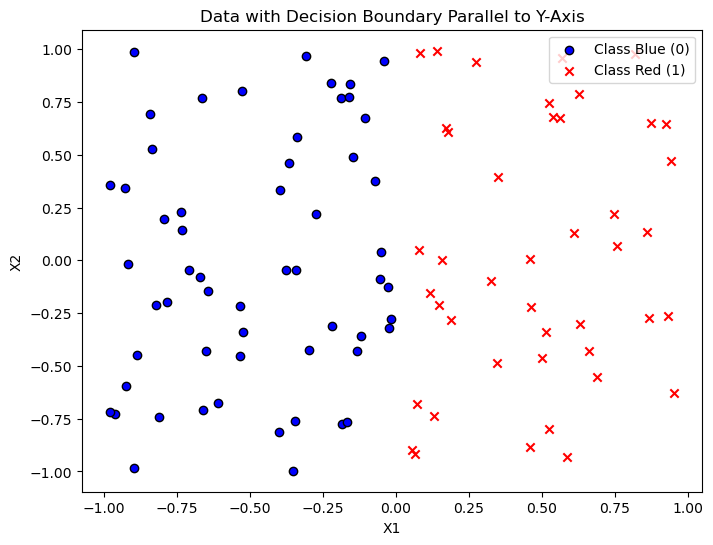

C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\3011500905.py:35: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



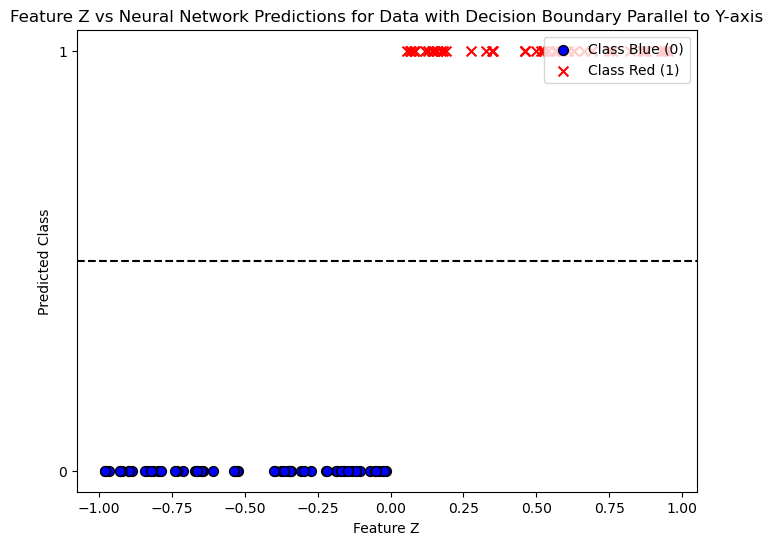

Decision Tree for Data having Linear with an axis-parallel Decision Boundary enhanced with Feature Z (Using NN Predictions)


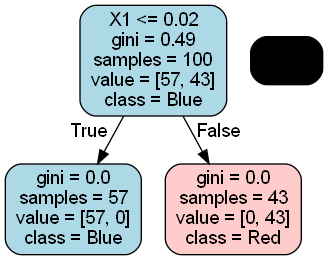

Decision Tree for Data having Linear with an axis-parallel Decision Boundary and without Feature Z (Using NN Predictions)


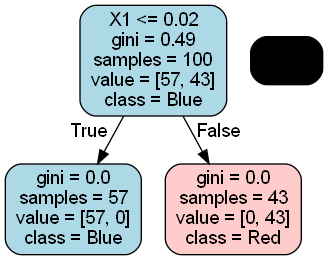

In [136]:
# Generate the data
X_lin = np.random.uniform(-1, 1, (100, 2))
y_lin = (X_lin[:, 0] > 0).astype(int)  # Decision boundary parallel to the y-axis

# Train a neural network on the data
nn_model_lin = MLPClassifier(hidden_layer_sizes=(20,), max_iter=1000, random_state=42)
nn_model_lin.fit(X_lin, y_lin)

# Neural network predictions
y_nn_pred_lin = nn_model_lin.predict(X_lin)

# Define feature Z as a linear combination for data
a, b = 1, 0
Z_lin = a * X_lin[:, 0] + b * X_lin[:, 1]

# Combine X and Z
X_combined_lin = np.column_stack((X_lin, Z_lin))

# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X_lin[y_lin == 0][:, 0], X_lin[y_lin == 0][:, 1], c='blue', edgecolors='k', marker='o', label='Class Blue (0)')
plt.scatter(X_lin[y_lin == 1][:, 0], X_lin[y_lin == 1][:, 1], c='red', edgecolors='k', marker='x', label='Class Red (1)')
plt.title("Data with Decision Boundary Parallel to Y-Axis")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='upper right')
plt.show()

# Plot Z against the neural network predictions for the data
plt.figure(figsize=(8, 6))
# Plot blue class points
plt.scatter(Z_lin[y_nn_pred_lin == 0], np.zeros(sum(y_nn_pred_lin == 0)),
            c='blue', edgecolors='k', marker='o', label='Class Blue (0)', s=50)
# Plot red class points
plt.scatter(Z_lin[y_nn_pred_lin == 1], np.ones(sum(y_nn_pred_lin == 1)),
            c='red', edgecolors='k', marker='x', label='Class Red (1)', s=50)
plt.axhline(0.5, color='black', linestyle='--')
plt.title("Feature Z vs Neural Network Predictions for Data with Decision Boundary Parallel to Y-axis")
plt.xlabel("Feature Z")
plt.ylabel("Predicted Class")
plt.yticks([0, 1], ['0', '1'])
plt.legend(loc='upper right')
plt.show()

# Train a decision tree on the data with derived feature Z using NN predictions
tree_model_lin = DecisionTreeClassifier(max_depth=1)
tree_model_lin.fit(X_combined_lin, y_nn_pred_lin)

# Train a decision tree on the data without derived feature Z using NN predictions
tree_model_lin_without_z = DecisionTreeClassifier(max_depth=1)
tree_model_lin_without_z.fit(X_lin, y_nn_pred_lin)

# Visualise the decision trees with and without feature Z for data
print("Decision Tree for Data having Linear with an axis-parallel Decision Boundary enhanced with Feature Z (Using NN Predictions)")
display(create_dtree(tree_model_lin))
print("Decision Tree for Data having Linear with an axis-parallel Decision Boundary and without Feature Z (Using NN Predictions)")
display(create_dtree_without_z(tree_model_lin_without_z))

In [137]:
# Get the condition and test its accuracy for the data
condition_lin, boolean_condition_lin = get_decision_tree_condition(tree_model_lin, X_lin, Z_lin, feature_names, classes)
print(f"Mathematical Condition formed by the Neural Network for Data having Linear with an axis-parallel Decision Boundary:\n{condition_lin}\n")

# Extract equation details
feature_index = tree_model_lin.tree_.feature[0]
threshold = tree_model_lin.tree_.threshold[0]

# Check accuracy
equation_accuracy = evaluate_equation_accuracy(X_combined_lin, y_nn_pred_lin, feature_index, threshold) * 100
print(f"Accuracy of the Equation: {equation_accuracy:.2f}%")

Mathematical Condition formed by the Neural Network for Data having Linear with an axis-parallel Decision Boundary:
IF X1 <= 0.020 ? Blue : Red

Accuracy of the Equation: 100.00%


### Comparison with Linear SVM in case of Data having Linear with an axis-parallel Decision Boundary

In [138]:
# Train Linear SVM
svm_model_lin = SVC(kernel='linear')
svm_model_lin.fit(X_combined_lin, y_nn_pred_lin)
y_pred_svm_lin = svm_model_lin.predict(X_combined_lin)

In [139]:
print(f"Neural Network Accuracy for Data having Linear with an axis-parallel Decision Boundary: {accuracy_score(y_lin, y_nn_pred_lin) * 100}%")
print(f"Decision Tree Accuracy for Data having Linear with an axis-parallel Decision Boundary: {accuracy_score(y_nn_pred_lin, tree_model_lin.predict(X_combined_lin)) * 100}%")
print(f"Decision Tree Accuracy without Z for Data having Linear with an axis-parallel Decision Boundary: {accuracy_score(y_nn_pred_lin, tree_model_lin_without_z.predict(X_lin)) * 100}%")
print(f"Linear SVM Accuracy for Data having Linear with an axis-parallel Decision Boundary: {accuracy_score(y_pred_svm_lin, y_nn_pred_lin) * 100}%")

Neural Network Accuracy for Data having Linear with an axis-parallel Decision Boundary: 100.0%
Decision Tree Accuracy for Data having Linear with an axis-parallel Decision Boundary: 100.0%
Decision Tree Accuracy without Z for Data having Linear with an axis-parallel Decision Boundary: 100.0%
Linear SVM Accuracy for Data having Linear with an axis-parallel Decision Boundary: 100.0%


### Evaluation Metrics

In [90]:
# Precision, Recall, F1-Score and ROC-AUC for Neural Network
precision_nn_lin = precision_score(y_lin, y_nn_pred_lin)
recall_nn_lin = recall_score(y_lin, y_nn_pred_lin)
f1_nn_lin = f1_score(y_lin, y_nn_pred_lin)

y_nn_pred_lin_prob = nn_model_lin.predict_proba(X_lin)[:, 1]
roc_auc_nn_lin = roc_auc_score(y_lin, y_nn_pred_lin_prob)

print(f"Neural Network Precision for Data having Linear with an axis-parallel Decision Boundary: {precision_nn_lin:.2f}")
print(f"Neural Network Recall for Data having Linear with an axis-parallel Decision Boundary: {recall_nn_lin:.2f}")
print(f"Neural Network F1-Score for Data having Linear with an axis-parallel Decision Boundary: {f1_nn_lin:.2f}")
print(f"Neural Network ROC-AUC for Data having Linear with an axis-parallel Decision Boundary: {roc_auc_nn_lin:.2f}")

Neural Network Precision for Data having Linear with an axis-parallel Decision Boundary: 1.00
Neural Network Recall for Data having Linear with an axis-parallel Decision Boundary: 1.00
Neural Network F1-Score for Data having Linear with an axis-parallel Decision Boundary: 1.00
Neural Network ROC-AUC for Data having Linear with an axis-parallel Decision Boundary: 1.00


In [91]:
# Precision, Recall, F1-Score and ROC-AUC for Decision Tree
precision_tree_lin = precision_score(y_nn_pred_lin, tree_model_lin.predict(X_combined_lin))
recall_tree_lin = recall_score(y_nn_pred_lin, tree_model_lin.predict(X_combined_lin))
f1_tree_lin = f1_score(y_nn_pred_lin, tree_model_lin.predict(X_combined_lin))

y_pred_tree_lin_prob = tree_model_lin.predict_proba(X_combined_lin)[:, 1]
roc_auc_tree_lin = roc_auc_score(y_nn_pred_lin, y_pred_tree_lin_prob)

print(f"Decision Tree Precision for Data having Linear with an axis-parallel Decision Boundary: {precision_tree_lin:.2f}")
print(f"Decision Tree Recall for Data having Linear with an axis-parallel Decision Boundary: {recall_tree_lin:.2f}")
print(f"Decision Tree F1-Score for Data having Linear with an axis-parallel Decision Boundary: {f1_tree_lin:.2f}")
print(f"Decision Tree ROC-AUC with Z for Data having Linear with an axis-parallel Decision Boundary: {roc_auc_tree_lin:.2f}")

Decision Tree Precision for Data having Linear with an axis-parallel Decision Boundary: 1.00
Decision Tree Recall for Data having Linear with an axis-parallel Decision Boundary: 1.00
Decision Tree F1-Score for Data having Linear with an axis-parallel Decision Boundary: 1.00
Decision Tree ROC-AUC with Z for Data having Linear with an axis-parallel Decision Boundary: 1.00


C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\1240052279.py:25: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



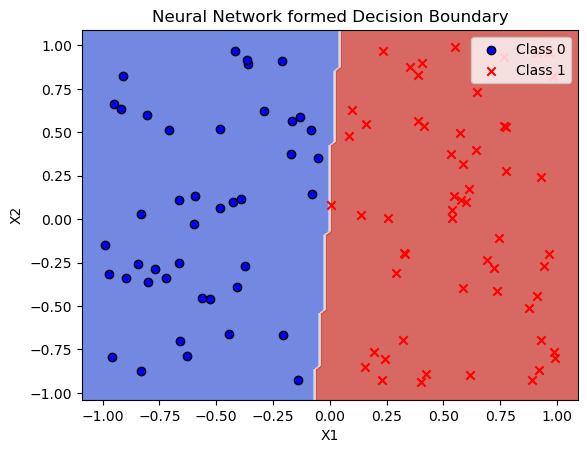

In [92]:
# Plot the neural network's decision boundary
plot_decision_boundary(nn_model_lin, X_lin, y_lin, title="Neural Network formed Decision Boundary")

## Case B : Data with Oblique Decision Boundary

C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\3238503639.py:25: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



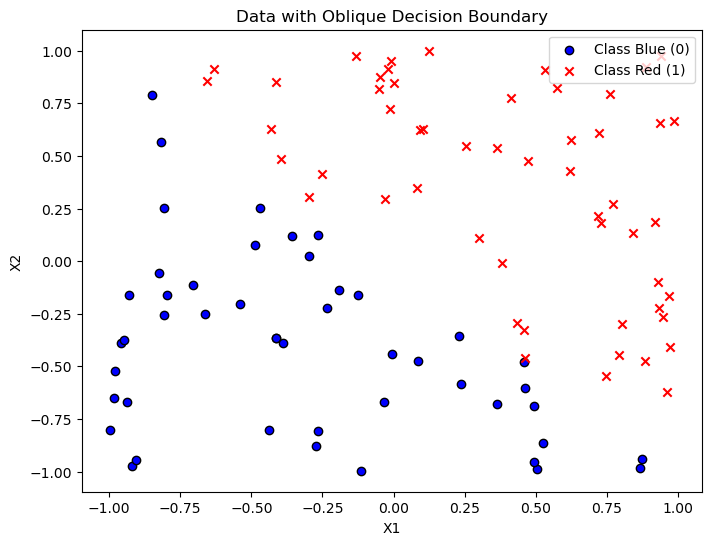

C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\3238503639.py:39: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



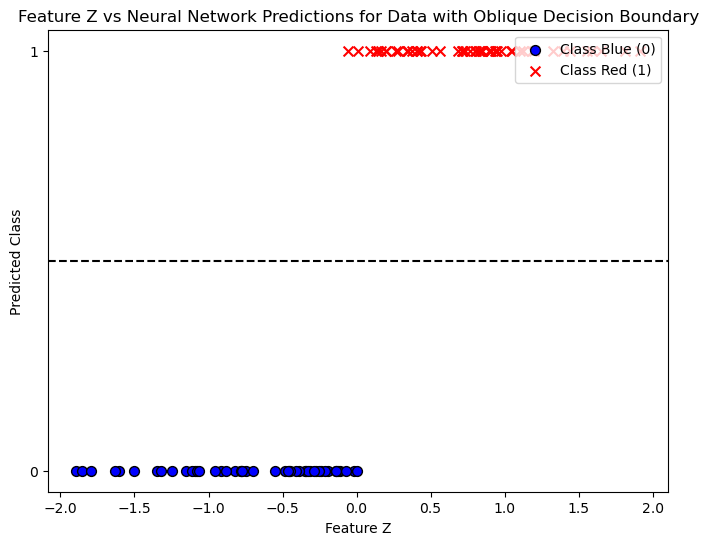

Decision Tree for Data with Oblique Decision Boundary enhanced with Feature Z (Using NN Predictions)


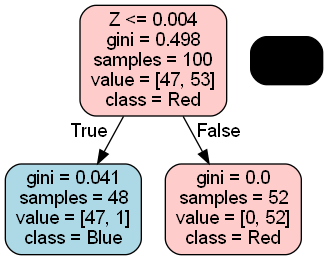

Decision Tree for Data with Oblique Decision Boundary and without Feature Z (Using NN Predictions)


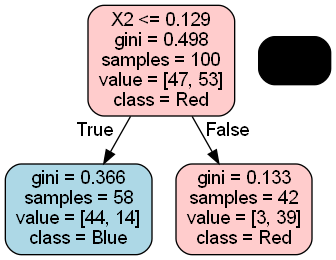

In [140]:
# Generate the data
X_linear = np.random.uniform(-1, 1, (100, 2))
y_linear = (X_linear[:, 0] + X_linear[:, 1] > 0).astype(int)  # Simple linear decision boundary

# Train a neural network on the data
nn_model_linear = MLPClassifier(hidden_layer_sizes=(20,), max_iter=1000, random_state=42)
nn_model_linear.fit(X_linear, y_linear)

# Neural network predictions
y_nn_pred_linear = nn_model_linear.predict(X_linear)

# Define feature Z as a linear combination for data
a, b = 1, 1
Z_linear = a * X_linear[:, 0] + b * X_linear[:, 1]

# Combine X and Z for training
X_combined_linear = np.column_stack((X_linear, Z_linear))

# Plot the data
plt.figure(figsize=(8, 6))
# Plot blue class points
plt.scatter(X_linear[y_linear == 0][:, 0], X_linear[y_linear == 0][:, 1], 
            c='blue', edgecolors='k', marker='o', label='Class Blue (0)')
# Plot red class points
plt.scatter(X_linear[y_linear == 1][:, 0], X_linear[y_linear == 1][:, 1], 
            c='red', edgecolors='k', marker='x', label='Class Red (1)')
plt.title("Data with Oblique Decision Boundary")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='upper right')  # Add a legend to distinguish between classes
plt.show()

# Plot Z against the neural network predictions for the data
plt.figure(figsize=(8, 6))
# Plot blue class points
plt.scatter(Z_linear[y_nn_pred_linear == 0], np.zeros(sum(y_nn_pred_linear == 0)),
            c='blue', edgecolors='k', marker='o', label='Class Blue (0)', s=50)  # Circle markers for blue
# Plot red class points
plt.scatter(Z_linear[y_nn_pred_linear == 1], np.ones(sum(y_nn_pred_linear == 1)),
            c='red', edgecolors='k', marker='x', label='Class Red (1)', s=50)  # Cross markers for red

plt.axhline(0.5, color='black', linestyle='--')  # Mid-line for reference
plt.title("Feature Z vs Neural Network Predictions for Data with Oblique Decision Boundary")
plt.xlabel("Feature Z")
plt.ylabel("Predicted Class")
plt.yticks([0, 1], ['0', '1'])  # Set y-axis ticks to match class labels
plt.legend(loc='upper right')
plt.show()

# Train a decision tree on the data with derived feature Z using NN predictions
tree_model_linear = DecisionTreeClassifier(max_depth=1)
tree_model_linear.fit(X_combined_linear, y_nn_pred_linear)

# Train a decision tree on the data without derived feature Z using NN predictions
tree_model_linear_without_z = DecisionTreeClassifier(max_depth=1)
tree_model_linear_without_z.fit(X_linear, y_nn_pred_linear)

# Visualise the decision trees with and without feature Z for data
print("Decision Tree for Data with Oblique Decision Boundary enhanced with Feature Z (Using NN Predictions)")
display(create_dtree(tree_model_linear))
print("Decision Tree for Data with Oblique Decision Boundary and without Feature Z (Using NN Predictions)")
display(create_dtree_without_z(tree_model_linear_without_z))

In [141]:
# Get the condition and test its accuracy for the data
condition_linear, boolean_condition_linear = get_decision_tree_condition(tree_model_linear, X_linear, Z_linear, feature_names, classes)
print(f"Mathematical Condition formed by the Neural Network for data having Oblique decision boundary:\n{condition_linear}\n")

# Extract equation details
feature_index = tree_model_linear.tree_.feature[0]
threshold = tree_model_linear.tree_.threshold[0]

# Check accuracy
equation_accuracy = evaluate_equation_accuracy(X_combined_linear, y_nn_pred_linear, feature_index, threshold) * 100
print(f"Accuracy of the Equation: {equation_accuracy:.2f}%")

Mathematical Condition formed by the Neural Network for data having Oblique decision boundary:
IF X1 + X2 <= 0.004 ? Blue : Red

Accuracy of the Equation: 99.00%


### Comparison with Linear SVM in case of Data having Linear Decision Boundary

In [142]:
# Train Linear SVM
svm_model_linear = SVC(kernel='linear')
svm_model_linear.fit(X_combined_linear, y_nn_pred_linear)
y_pred_svm = svm_model_linear.predict(X_combined_linear)

In [144]:
print(f"Neural Network Accuracy for Data having Oblique Decision Boundary: {accuracy_score(y_linear, y_nn_pred_linear) * 100}%")
print(f"Decision Tree Accuracy for Data having Oblique Decision Boundary: {accuracy_score(y_nn_pred_linear, tree_model_linear.predict(X_combined_linear)) * 100}%")
print(f"Decision Tree Accuracy without Z for Data having Oblique Decision Boundary: {accuracy_score(y_nn_pred_linear, tree_model_linear_without_z.predict(X_linear)) * 100}%")
print(f"Linear SVM Accuracy for Data having Oblique Decision Boundary: {accuracy_score(y_pred_svm, y_nn_pred_linear) * 100}%")

Neural Network Accuracy for Data having Oblique Decision Boundary: 98.0%
Decision Tree Accuracy for Data having Oblique Decision Boundary: 99.0%
Decision Tree Accuracy without Z for Data having Oblique Decision Boundary: 83.0%
Linear SVM Accuracy for Data having Oblique Decision Boundary: 100.0%


### Evaluation Metrics

In [145]:
# Precision, Recall, F1-Score and ROC-AUC for Neural Network
precision_nn_linear = precision_score(y_linear, y_nn_pred_linear)
recall_nn_linear = recall_score(y_linear, y_nn_pred_linear)
f1_nn_linear = f1_score(y_linear, y_nn_pred_linear)

y_nn_pred_linear_prob = nn_model_linear.predict_proba(X_linear)[:, 1]
roc_auc_nn_linear = roc_auc_score(y_linear, y_nn_pred_linear_prob)

print(f"Neural Network Precision for Data having Oblique Decision Boundary: {precision_nn_linear:.2f}")
print(f"Neural Network Recall for Data having Oblique Decision Boundary: {recall_nn_linear:.2f}")
print(f"Neural Network F1-Score for Data having Oblique Decision Boundary: {f1_nn_linear:.2f}")
print(f"Neural Network ROC-AUC for Data having Oblique Decision Boundary: {roc_auc_nn_linear:.2f}")

Neural Network Precision for Data having Oblique Decision Boundary: 0.98
Neural Network Recall for Data having Oblique Decision Boundary: 0.98
Neural Network F1-Score for Data having Oblique Decision Boundary: 0.98
Neural Network ROC-AUC for Data having Oblique Decision Boundary: 1.00


In [146]:
# Precision, Recall, F1-Score and ROC-AUC for Decision Tree
precision_tree_linear = precision_score(y_nn_pred_linear, tree_model_linear.predict(X_combined_linear))
recall_tree_linear = recall_score(y_nn_pred_linear, tree_model_linear.predict(X_combined_linear))
f1_tree_linear = f1_score(y_nn_pred_linear, tree_model_linear.predict(X_combined_linear))

y_pred_tree_linear_prob = tree_model_linear.predict_proba(X_combined_linear)[:, 1]
roc_auc_tree_linear = roc_auc_score(y_nn_pred_linear, y_pred_tree_linear_prob)

print(f"Decision Tree Precision for Data having Oblique Decision Boundary: {precision_tree_linear:.2f}")
print(f"Decision Tree Recall for Data having Oblique Decision Boundary: {recall_tree_linear:.2f}")
print(f"Decision Tree F1-Score for Data having Oblique Decision Boundary: {f1_tree_linear:.2f}")
print(f"Decision Tree ROC-AUC with Z for Data having Oblique Decision Boundary: {roc_auc_tree_linear:.2f}")

Decision Tree Precision for Data having Oblique Decision Boundary: 1.00
Decision Tree Recall for Data having Oblique Decision Boundary: 0.98
Decision Tree F1-Score for Data having Oblique Decision Boundary: 0.99
Decision Tree ROC-AUC with Z for Data having Oblique Decision Boundary: 0.99


C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\1240052279.py:25: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



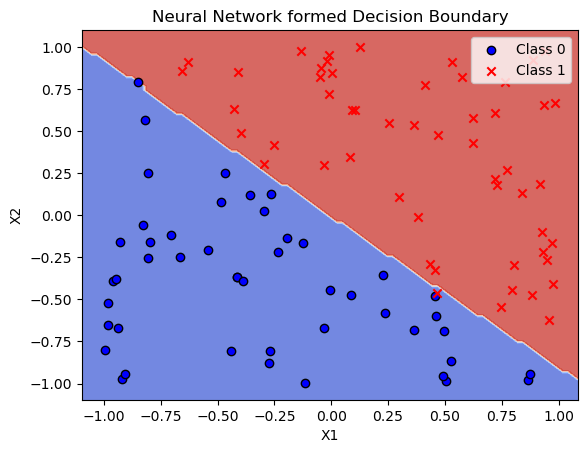

In [147]:
# Plot the neural network's decision boundary
plot_decision_boundary(nn_model_linear, X_linear, y_linear, title="Neural Network formed Decision Boundary")

## Case C : Data with Circular Decision Boundary

C:\Users\sanyo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\1252997498.py:24: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



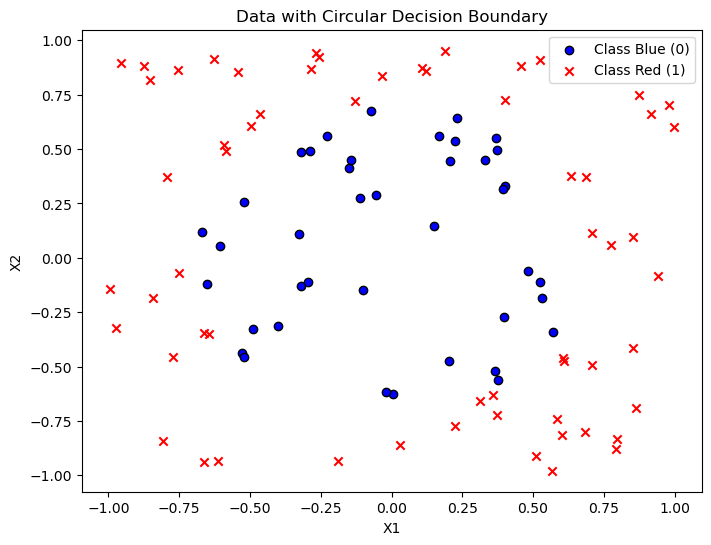

C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\1252997498.py:38: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



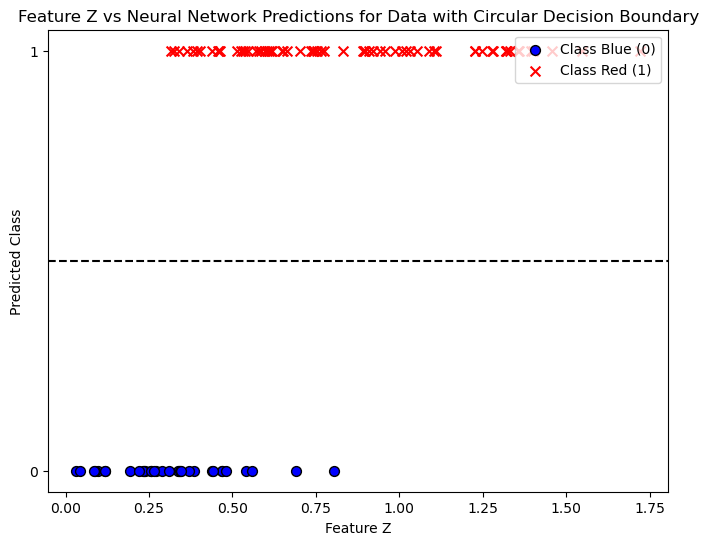

Decision Tree for Data with Circular Decision Boundary enhanced with Feature Z (Using NN Predictions)


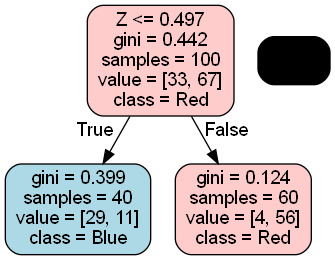

Decision Tree for Data with Circular Decision Boundary and without Feature Z (Using NN Predictions)


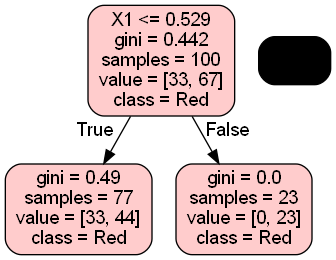

In [148]:
# Generate the data
X_circular = np.random.uniform(-1, 1, (100, 2))
y_circular = (X_circular[:, 0]**2 + X_circular[:, 1]**2 > 0.5).astype(int)  # Simple circular decision boundary

# Train a neural network on the data
nn_model_circular = MLPClassifier(hidden_layer_sizes=(20,), max_iter=1000, random_state=42)
nn_model_circular.fit(X_circular, y_circular)

# Neural network predictions for the data
y_nn_pred_circular = nn_model_circular.predict(X_circular)

# Define feature Z as the sum of squares for the data
Z_circular = X_circular[:, 0]**2 + X_circular[:, 1]**2

# Combine X and Z for training the decision tree
X_combined_circular = np.column_stack((X_circular, Z_circular))

# Plot the original data
plt.figure(figsize=(8, 6))
# Plot blue class points
plt.scatter(X_circular[y_circular == 0][:, 0], X_circular[y_circular == 0][:, 1], 
            c='blue', edgecolors='k', marker='o', label='Class Blue (0)')
# Plot red class points
plt.scatter(X_circular[y_circular == 1][:, 0], X_circular[y_circular == 1][:, 1], 
            c='red', edgecolors='k', marker='x', label='Class Red (1)')
plt.title("Data with Circular Decision Boundary")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='upper right')
plt.show()

# Plot Z against the neural network predictions for the data
plt.figure(figsize=(8, 6))
# Plot blue class points
plt.scatter(Z_circular[y_nn_pred_circular == 0], np.zeros(sum(y_nn_pred_circular == 0)),
            c='blue', edgecolors='k', marker='o', label='Class Blue (0)', s=50)  # Circle markers for blue
# Plot red class points
plt.scatter(Z_circular[y_nn_pred_circular == 1], np.ones(sum(y_nn_pred_circular == 1)),
            c='red', edgecolors='k', marker='x', label='Class Red (1)', s=50)  # Cross markers for red
plt.axhline(0.5, color='black', linestyle='--')
plt.title("Feature Z vs Neural Network Predictions for Data with Circular Decision Boundary")
plt.xlabel("Feature Z")
plt.ylabel("Predicted Class")
plt.yticks([0, 1], ['0', '1'])
plt.legend(loc='upper right')
plt.show()

# Train a decision tree on the data with derived feature Z using NN predictions
tree_model_circular = DecisionTreeClassifier(max_depth=1)
tree_model_circular.fit(X_combined_circular, y_nn_pred_circular)

# Train a decision tree on the data without derived feature Z using NN predictions
tree_model_circular_without_z = DecisionTreeClassifier(max_depth=1)
tree_model_circular_without_z.fit(X_circular, y_nn_pred_circular)

# Visualize the decision trees with and without feature Z for circular data
print("Decision Tree for Data with Circular Decision Boundary enhanced with Feature Z (Using NN Predictions)")
display(create_dtree(tree_model_circular))
print("Decision Tree for Data with Circular Decision Boundary and without Feature Z (Using NN Predictions)")
display(create_dtree_without_z(tree_model_circular_without_z))

In [149]:
# Get the condition and test its accuracy for circular data
condition_circular, boolean_condition_circular = get_decision_tree_condition(tree_model_circular, X_circular, Z_circular, feature_names, classes)
print(f"Mathematical Condition formed by the Neural Network for data having Circular decision boundary:\n{condition_circular}\n")

# Extract equation details
feature_index = tree_model_circular.tree_.feature[0]
threshold = tree_model_circular.tree_.threshold[0]

# Check accuracy
equation_accuracy = evaluate_equation_accuracy(X_combined_circular, y_nn_pred_circular, feature_index, threshold) * 100
print(f"Accuracy of the Equation: {equation_accuracy:.2f}%")

Mathematical Condition formed by the Neural Network for data having Circular decision boundary:
IF X1**2 + X2**2 <= 0.497 ? Blue : Red

Accuracy of the Equation: 85.00%


### Comparison with Logistic Regression having polynomial features in case of data having circular decision boundary

In [150]:
# Train Logistic Regression with Polynomial Features
poly_logistic = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('logit', LogisticRegression())
])
poly_logistic.fit(X_combined_circular, y_circular)
y_pred_poly_logistic = poly_logistic.predict(X_combined_circular)

In [109]:
print(f"Neural Network Accuracy for Data having Circular Decision Boundary: {accuracy_score(y_circular, y_nn_pred_circular) * 100}%")
print(f"Decision Tree Accuracy for Data having Circular Decision Boundary: {accuracy_score(y_nn_pred_circular, tree_model_circular.predict(X_combined_circular)) * 100}%")
print(f"Decision Tree Accuracy without Z for Data having Circular Decision Boundary: {accuracy_score(y_nn_pred_circular, tree_model_circular_without_z.predict(X_circular)) * 100}%")
print(f"Logistic Regression Accuracy for Data having Circular Decision Boundary: {accuracy_score(y_nn_pred_circular, y_pred_poly_logistic) * 100}%")

Neural Network Accuracy for Data having Circular Decision Boundary: 88.0%
Decision Tree Accuracy for Data having Circular Decision Boundary: 95.0%
Decision Tree Accuracy without Z for Data having Circular Decision Boundary: 68.0%
Logistic Regression Accuracy for Data having Circular Decision Boundary: 90.0%


### Evaluation Metrics

In [110]:
# Precision, Recall, F1-Score and ROC-AUC for Neural Network
precision_nn_circular = precision_score(y_circular, y_nn_pred_circular)
recall_nn_circular = recall_score(y_circular, y_nn_pred_circular)
f1_nn_circular = f1_score(y_circular, y_nn_pred_circular)

y_nn_pred_circular_prob = nn_model_circular.predict_proba(X_circular)[:, 1]  # Predicted probabilities
roc_auc_nn_circular = roc_auc_score(y_circular, y_nn_pred_circular_prob)

print(f"Neural Network Precision for Data having circular Decision Boundary: {precision_nn_circular:.2f}")
print(f"Neural Network Recall for Data having circular Decision Boundary: {recall_nn_circular:.2f}")
print(f"Neural Network F1-Score for Data having circular Decision Boundary: {f1_nn_circular:.2f}")
print(f"Neural Network ROC-AUC for Data having circular Decision Boundary: {roc_auc_nn_circular:.2f}")

Neural Network Precision for Data having circular Decision Boundary: 0.88
Neural Network Recall for Data having circular Decision Boundary: 0.94
Neural Network F1-Score for Data having circular Decision Boundary: 0.91
Neural Network ROC-AUC for Data having circular Decision Boundary: 0.95


In [113]:
# Precision, Recall, F1-Score and ROC-AUC for Decision Tree
precision_tree_circular = precision_score(y_nn_pred_circular, tree_model_circular.predict(X_combined_circular))
recall_tree_circular = recall_score(y_nn_pred_circular, tree_model_circular.predict(X_combined_circular))
f1_tree_circular = f1_score(y_nn_pred_circular, tree_model_circular.predict(X_combined_circular))

y_pred_tree_circular_prob = tree_model_circular.predict_proba(X_combined_circular)[:, 1]
roc_auc_tree_circular = roc_auc_score(y_nn_pred_circular, y_pred_tree_circular_prob)

print(f"Decision Tree Precision for Data having circular Decision Boundary: {precision_tree_circular:.2f}")
print(f"Decision Tree Recall for Data having circular Decision Boundary: {recall_tree_circular:.2f}")
print(f"Decision Tree F1-Score for Data having circular Decision Boundary: {f1_tree_circular:.2f}")
print(f"Decision Tree ROC-AUC with Z for Data having circular Decision Boundary: {roc_auc_tree_circular:.2f}")

Decision Tree Precision for Data having circular Decision Boundary: 0.94
Decision Tree Recall for Data having circular Decision Boundary: 0.98
Decision Tree F1-Score for Data having circular Decision Boundary: 0.96
Decision Tree ROC-AUC with Z for Data having circular Decision Boundary: 0.93


C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\1240052279.py:25: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



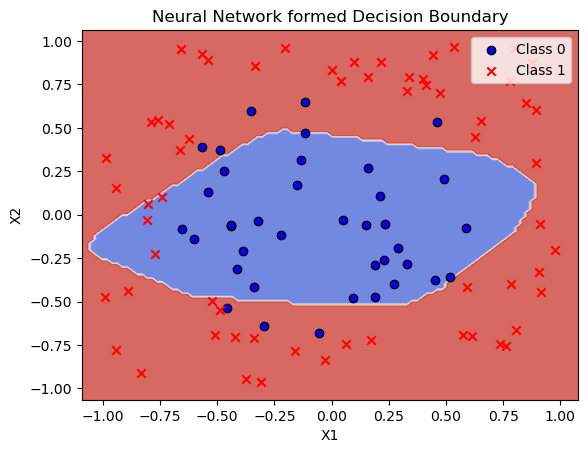

In [114]:
# Plot the neural network's decision boundary
plot_decision_boundary(nn_model_circular, X_circular, y_circular, title="Neural Network formed Decision Boundary")

## Case D : Data with Elliptical Decision Boundary

C:\Users\sanyo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\3583253958.py:26: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



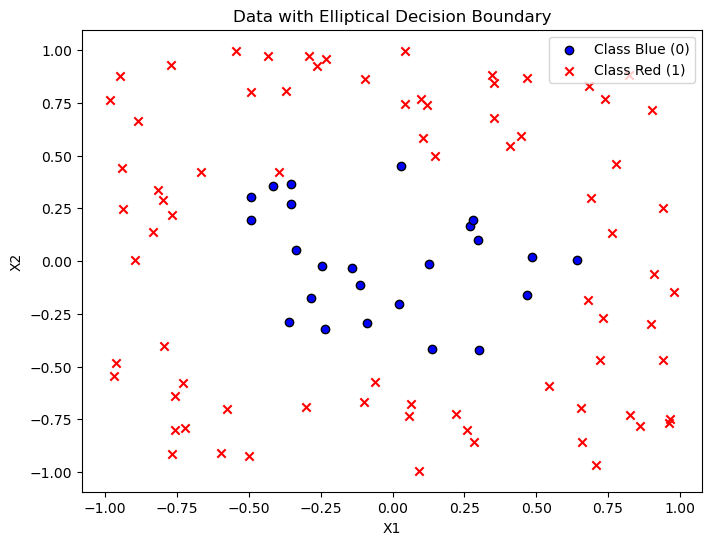

C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\3583253958.py:40: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



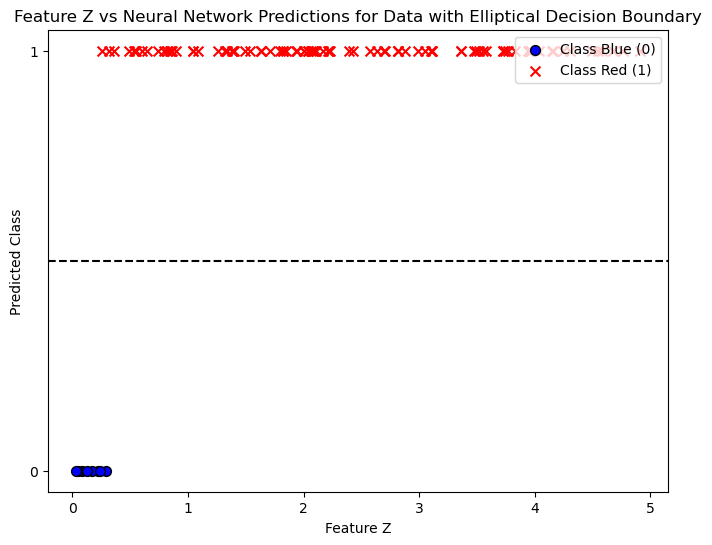

Decision Tree for Data with Elliptical Decision Boundary enhanced with Feature Z (Using NN Predictions)


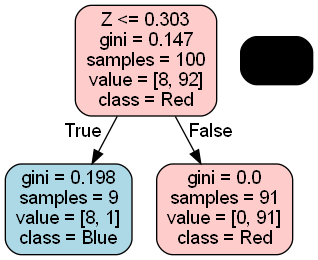

Decision Tree for Data with Elliptical Decision Boundary and without Feature Z (Using NN Predictions)


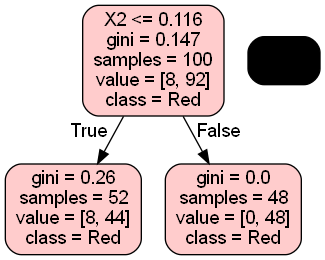

In [115]:
# Generate the data
X_ellipse = np.random.uniform(-1, 1, (100, 2))
# Define the elliptical decision boundary: (X1^2 / a^2) + (X2^2 / b^2) = 1
a, b = 0.7, 0.5  # Semi-major and semi-minor axes
y_ellipse = ((X_ellipse[:, 0]**2 / a**2) + (X_ellipse[:, 1]**2 / b**2) > 1).astype(int)  # Elliptical decision boundary

# Train a neural network on the data
nn_model_ellipse = MLPClassifier(hidden_layer_sizes=(20,), max_iter=1000, random_state=42)
nn_model_ellipse.fit(X_ellipse, y_ellipse)

# Neural network predictions for the data
y_nn_pred_ellipse = nn_model_ellipse.predict(X_ellipse)

# Define feture Z as the elliptical transformation for the data
Z_ellipse = (X_ellipse[:, 0]**2 / a**2) + (X_ellipse[:, 1]**2 / b**2)

# Combine X and Z
X_combined_ellipse = np.column_stack((X_ellipse, Z_ellipse))

# Plot the original data
plt.figure(figsize=(8, 6))
# Plot blue class points
plt.scatter(X_ellipse[y_ellipse == 0][:, 0], X_ellipse[y_ellipse == 0][:, 1], 
            c='blue', edgecolors='k', marker='o', label='Class Blue (0)')
# Plot red class points
plt.scatter(X_ellipse[y_ellipse == 1][:, 0], X_ellipse[y_ellipse == 1][:, 1], 
            c='red', edgecolors='k', marker='x', label='Class Red (1)')
plt.title("Data with Elliptical Decision Boundary")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='upper right')
plt.show()

# Plot Z against the neural network predictions for the data
plt.figure(figsize=(8, 6))
# Plot blue class points
plt.scatter(Z_ellipse[y_nn_pred_ellipse == 0], np.zeros(sum(y_nn_pred_ellipse == 0)),
            c='blue', edgecolors='k', marker='o', label='Class Blue (0)', s=50)  # Circle markers for blue
# Plot red class points
plt.scatter(Z_ellipse[y_nn_pred_ellipse == 1], np.ones(sum(y_nn_pred_ellipse == 1)),
            c='red', edgecolors='k', marker='x', label='Class Red (1)', s=50)  # Cross markers for red
plt.axhline(0.5, color='black', linestyle='--')  # Mid-line for reference
plt.title("Feature Z vs Neural Network Predictions for Data with Elliptical Decision Boundary")
plt.xlabel("Feature Z")
plt.ylabel("Predicted Class")
plt.yticks([0, 1], ['0', '1'])
plt.legend(loc='upper right')
plt.show()

# Train a decision tree on the data with derived feature Z using NN predictions
tree_model_ellipse = DecisionTreeClassifier(max_depth=1)
tree_model_ellipse.fit(X_combined_ellipse, y_nn_pred_ellipse)

# Train a decision tree on the data without derived feature Z using NN predictions
tree_model_ellipse_without_z = DecisionTreeClassifier(max_depth=1)
tree_model_ellipse_without_z.fit(X_ellipse, y_nn_pred_ellipse)

# Visualize the decision trees with and without feature Z for the data
print("Decision Tree for Data with Elliptical Decision Boundary enhanced with Feature Z (Using NN Predictions)")
display(create_dtree(tree_model_ellipse))
print("Decision Tree for Data with Elliptical Decision Boundary and without Feature Z (Using NN Predictions)")
display(create_dtree_without_z(tree_model_ellipse_without_z))

In [116]:
# Get the condition and test its accuracy for circular data
condition_ellipse, boolean_condition_ellipse = get_decision_tree_condition(tree_model_ellipse, X_ellipse, Z_ellipse, feature_names, classes)
print(f"Mathematical Condition formed by the Neural Network for data having Elliptical decision boundary:\n{condition_ellipse}\n")

# Extract equation details
feature_index = tree_model_ellipse.tree_.feature[0]
threshold = tree_model_ellipse.tree_.threshold[0]

# Check accuracy
equation_accuracy = evaluate_equation_accuracy(X_combined_ellipse, y_nn_pred_ellipse, feature_index, threshold) * 100
print(f"Accuracy of the Equation: {equation_accuracy:.2f}%")

Mathematical Condition formed by the Neural Network for data having Elliptical decision boundary:
IF X1**2/a**2 + X2**2/b**2 <= 0.303 ? Blue : Red

Accuracy of the Equation: 99.00%


In [117]:
print(f"Neural Network Accuracy for Data having Elliptical Decision Boundary: {accuracy_score(y_ellipse, y_nn_pred_ellipse) * 100}%")
print(f"Decision Tree Accuracy for Data having Elliptical Decision Boundary: {accuracy_score(y_nn_pred_ellipse, tree_model_ellipse.predict(X_combined_ellipse)) * 100}%")
print(f"Decision Tree Accuracy without Z for Data having Elliptical Decision Boundary: {accuracy_score(y_nn_pred_ellipse, tree_model_ellipse_without_z.predict(X_ellipse)) * 100}%")

Neural Network Accuracy for Data having Elliptical Decision Boundary: 84.0%
Decision Tree Accuracy for Data having Elliptical Decision Boundary: 99.0%
Decision Tree Accuracy without Z for Data having Elliptical Decision Boundary: 92.0%


### Evaluation Metrics

In [120]:
# Precision, Recall, F1-Score and ROC-AUC for Neural Network
precision_nn_ellipse = precision_score(y_ellipse, y_nn_pred_ellipse)
recall_nn_ellipse = recall_score(y_ellipse, y_nn_pred_ellipse)
f1_nn_ellipse = f1_score(y_ellipse, y_nn_pred_ellipse)

y_nn_pred_ellipse_prob = nn_model_ellipse.predict_proba(X_ellipse)[:, 1]  # Predicted probabilities
roc_auc_nn_ellipse = roc_auc_score(y_ellipse, y_nn_pred_ellipse_prob)

print(f"Neural Network Precision for Data having elliptical Decision Boundary: {precision_nn_ellipse:.2f}")
print(f"Neural Network Recall for Data having elliptical Decision Boundary: {recall_nn_ellipse:.2f}")
print(f"Neural Network F1-Score for Data having elliptical Decision Boundary: {f1_nn_ellipse:.2f}")
print(f"Neural Network ROC-AUC for Data having elliptical Decision Boundary: {roc_auc_nn_ellipse:.2f}")

Neural Network Precision for Data having elliptical Decision Boundary: 0.83
Neural Network Recall for Data having elliptical Decision Boundary: 1.00
Neural Network F1-Score for Data having elliptical Decision Boundary: 0.90
Neural Network ROC-AUC for Data having elliptical Decision Boundary: 1.00


In [121]:
# Precision, Recall, F1-Score and ROC-AUC for Decision Tree
precision_tree_ellipse = precision_score(y_nn_pred_ellipse, tree_model_ellipse.predict(X_combined_ellipse))
recall_tree_ellipse = recall_score(y_nn_pred_ellipse, tree_model_ellipse.predict(X_combined_ellipse))
f1_tree_ellipse = f1_score(y_nn_pred_ellipse, tree_model_ellipse.predict(X_combined_ellipse))

y_pred_tree_ellipse_prob = tree_model_ellipse.predict_proba(X_combined_ellipse)[:, 1]
roc_auc_tree_ellipse = roc_auc_score(y_nn_pred_ellipse, y_pred_tree_ellipse_prob)

print(f"Decision Tree Precision for Data having elliptical Decision Boundary: {precision_tree_ellipse:.2f}")
print(f"Decision Tree Recall for Data having elliptical Decision Boundary: {recall_tree_ellipse:.2f}")
print(f"Decision Tree F1-Score for Data having elliptical Decision Boundary: {f1_tree_ellipse:.2f}")
print(f"Decision Tree ROC-AUC with Z for Data having elliptical Decision Boundary: {roc_auc_tree_ellipse:.2f}")

Decision Tree Precision for Data having elliptical Decision Boundary: 1.00
Decision Tree Recall for Data having elliptical Decision Boundary: 0.99
Decision Tree F1-Score for Data having elliptical Decision Boundary: 0.99
Decision Tree ROC-AUC with Z for Data having elliptical Decision Boundary: 0.99


C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\1240052279.py:25: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



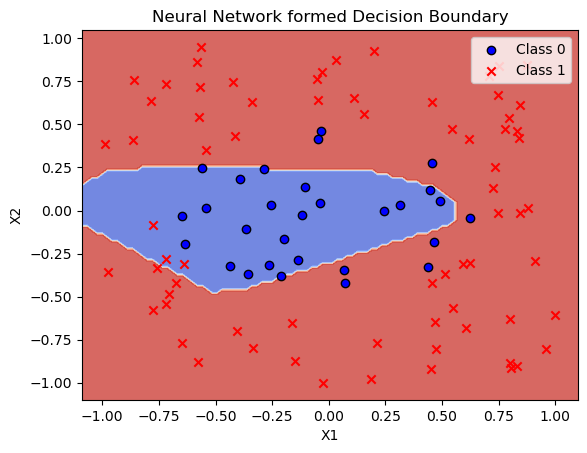

In [52]:
# Plot the neural network's decision boundary
plot_decision_boundary(nn_model_ellipse, X_ellipse, y_ellipse, title="Neural Network formed Decision Boundary")

## Case E: Data with Square-shaped Decision Boundary

C:\Users\sanyo\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.

C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\2339356062.py:26: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



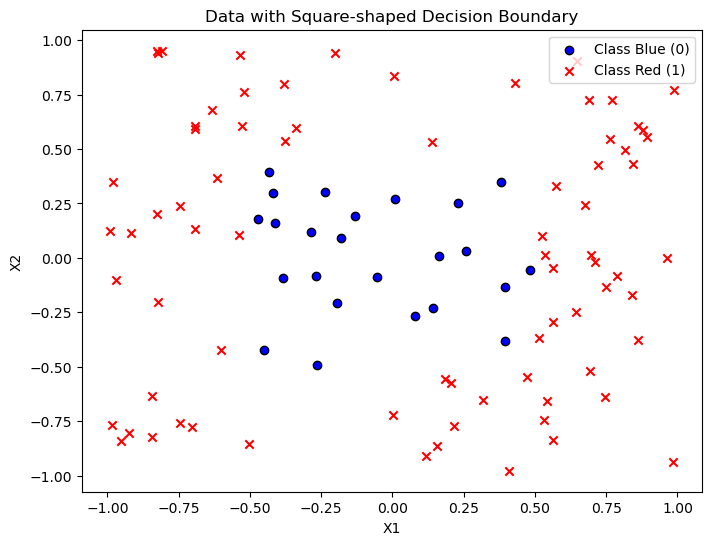

C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\2339356062.py:41: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



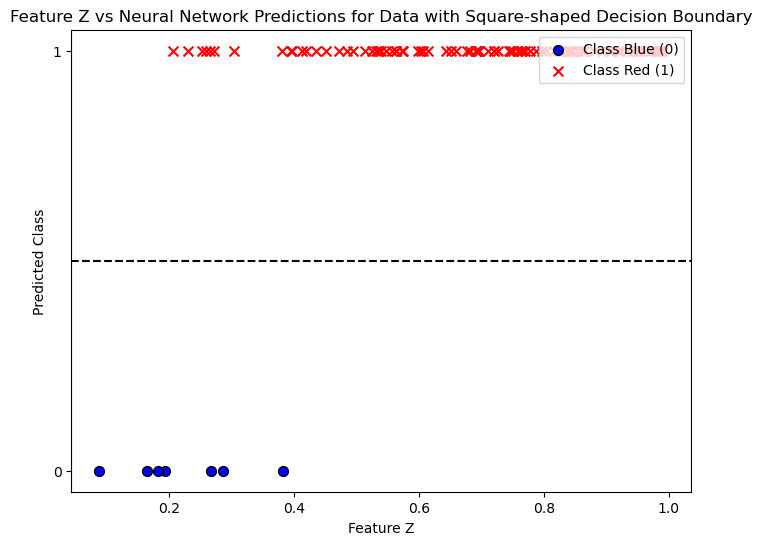

Decision Tree for Data with Square-shaped Decision Boundary enhanced with Feature Z (Using NN Predictions)


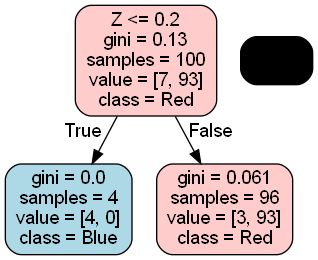

Decision Tree for Data with Square-shaped Decision Boundary and without Feature Z (Using NN Predictions)


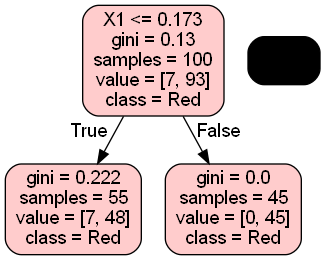

In [122]:
# Step 1: Generate the data
X_square = np.random.uniform(-1, 1, (100, 2))
# Define the square decision boundary: max(abs(X1), abs(X2)) = threshold
threshold = 0.5
y_square = (np.maximum(np.abs(X_square[:, 0]), np.abs(X_square[:, 1])) > threshold).astype(int)  # Square decision boundary

# Train a neural network on the data
nn_model_square = MLPClassifier(hidden_layer_sizes=(20,), max_iter=1000, random_state=42)
nn_model_square.fit(X_square, y_square)

# Neural network predictions for the data
y_nn_pred_square = nn_model_square.predict(X_square)

# Define feature Z as the square transformation for the data
Z_square = np.maximum(np.abs(X_square[:, 0]), np.abs(X_square[:, 1]))

# Combine X and Z for training the decision tree
X_combined_square = np.column_stack((X_square, Z_square))

# Plot the original data
plt.figure(figsize=(8, 6))
# Plot blue class points
plt.scatter(X_square[y_square == 0][:, 0], X_square[y_square == 0][:, 1], 
            c='blue', edgecolors='k', marker='o', label='Class Blue (0)')
# Plot red class points
plt.scatter(X_square[y_square == 1][:, 0], X_square[y_square == 1][:, 1], 
            c='red', edgecolors='k', marker='x', label='Class Red (1)')

plt.title("Data with Square-shaped Decision Boundary")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(loc='upper right')  # Add a legend to distinguish between classes
plt.show()

# Plot Z against the neural network predictions for the data
plt.figure(figsize=(8, 6))
# Plot blue class points
plt.scatter(Z_square[y_nn_pred_square == 0], np.zeros(sum(y_nn_pred_square == 0)),
            c='blue', edgecolors='k', marker='o', label='Class Blue (0)', s=50)  # Circle markers for blue
# Plot red class points
plt.scatter(Z_square[y_nn_pred_square == 1], np.ones(sum(y_nn_pred_square == 1)),
            c='red', edgecolors='k', marker='x', label='Class Red (1)', s=50)  # Cross markers for red

plt.axhline(0.5, color='black', linestyle='--')  # Mid-line for reference
plt.title("Feature Z vs Neural Network Predictions for Data with Square-shaped Decision Boundary")
plt.xlabel("Feature Z")
plt.ylabel("Predicted Class")
plt.yticks([0, 1], ['0', '1'])  # Set y-axis ticks to match class labels
plt.legend(loc='upper right')
plt.show()

# Step 2: Train a decision tree on the data using NN predictions
tree_model_square = DecisionTreeClassifier(max_depth=1)
tree_model_square.fit(X_combined_square, y_nn_pred_square)

# Step 3: Train a decision tree on the data without Z
tree_model_square_without_z = DecisionTreeClassifier(max_depth=1)
tree_model_square_without_z.fit(X_square, y_nn_pred_square)

# Visualize the decision trees with and without feature Z for the data
print("Decision Tree for Data with Square-shaped Decision Boundary enhanced with Feature Z (Using NN Predictions)")
display(create_dtree(tree_model_square))
print("Decision Tree for Data with Square-shaped Decision Boundary and without Feature Z (Using NN Predictions)")
display(create_dtree_without_z(tree_model_square_without_z))

In [123]:
# Get the condition and test its accuracy for circular data
condition_square, boolean_condition_square = get_decision_tree_condition(tree_model_square, X_square, Z_square, feature_names, classes)
print(f"Mathematical Condition formed by the Neural Network for data having Square-shaped decision boundary:\n{condition_square}\n")

# Extract equation details
feature_index = tree_model_square.tree_.feature[0]
threshold = tree_model_square.tree_.threshold[0]

# Check accuracy
equation_accuracy = evaluate_equation_accuracy(X_combined_square, y_nn_pred_square, feature_index, threshold) * 100
print(f"Accuracy of the Equation: {equation_accuracy:.2f}%")

Mathematical Condition formed by the Neural Network for data having Square-shaped decision boundary:
IF max(abs(X1), abs(X2)) <= 0.200 ? Blue : Red

Accuracy of the Equation: 97.00%


In [124]:
print(f"Neural Network Accuracy for Data having Square-shaped Decision Boundary: {accuracy_score(y_square, y_nn_pred_square) * 100}%")
print(f"Decision Tree Accuracy for Data having Square-shaped Decision Boundary: {accuracy_score(y_nn_pred_square, tree_model_square.predict(X_combined_square)) * 100}%")
print(f"Decision Tree Accuracy without Z for Data having Square-shaped Decision Boundary: {accuracy_score(y_nn_pred_square, tree_model_square_without_z.predict(X_square)) * 100}%")

Neural Network Accuracy for Data having Square-shaped Decision Boundary: 83.0%
Decision Tree Accuracy for Data having Square-shaped Decision Boundary: 97.0%
Decision Tree Accuracy without Z for Data having Square-shaped Decision Boundary: 93.0%


### Evaluation Metrics

In [125]:
# Precision, Recall, F1-Score and ROC-AUC for Neural Network
precision_nn_square = precision_score(y_square, y_nn_pred_square)
recall_nn_square = recall_score(y_square, y_nn_pred_square)
f1_nn_square = f1_score(y_square, y_nn_pred_square)

y_nn_pred_square_prob = nn_model_square.predict_proba(X_square)[:, 1]  # Predicted probabilities
roc_auc_nn_square = roc_auc_score(y_square, y_nn_pred_square_prob)

print(f"Neural Network Precision for Data having square-shaped Decision Boundary: {precision_nn_square:.2f}")
print(f"Neural Network Recall for Data having square-shaped Decision Boundary: {recall_nn_square:.2f}")
print(f"Neural Network F1-Score for Data having square-shaped Decision Boundary: {f1_nn_square:.2f}")
print(f"Neural Network ROC-AUC for Data having square-shaped Decision Boundary: {roc_auc_nn_square:.2f}")

Neural Network Precision for Data having square-shaped Decision Boundary: 0.82
Neural Network Recall for Data having square-shaped Decision Boundary: 1.00
Neural Network F1-Score for Data having square-shaped Decision Boundary: 0.90
Neural Network ROC-AUC for Data having square-shaped Decision Boundary: 0.97


In [126]:
# Precision, Recall, F1-Score and ROC-AUC for Decision Tree
precision_tree_square = precision_score(y_nn_pred_square, tree_model_square.predict(X_combined_square))
recall_tree_square = recall_score(y_nn_pred_square, tree_model_square.predict(X_combined_square))
f1_tree_square = f1_score(y_nn_pred_square, tree_model_square.predict(X_combined_square))

y_pred_tree_square_prob = tree_model_square.predict_proba(X_combined_square)[:, 1]
roc_auc_tree_square = roc_auc_score(y_nn_pred_square, y_pred_tree_square_prob)


print(f"Decision Tree Precision for Data having square Decision Boundary: {precision_tree_square:.2f}")
print(f"Decision Tree Recall for Data having square Decision Boundary: {recall_tree_square:.2f}")
print(f"Decision Tree F1-Score for Data having square Decision Boundary: {f1_tree_square:.2f}")
print(f"Decision Tree ROC-AUC with Z for Data having square-shaped Decision Boundary: {roc_auc_tree_square:.2f}")

Decision Tree Precision for Data having square Decision Boundary: 0.97
Decision Tree Recall for Data having square Decision Boundary: 1.00
Decision Tree F1-Score for Data having square Decision Boundary: 0.98
Decision Tree ROC-AUC with Z for Data having square-shaped Decision Boundary: 0.79


C:\Users\sanyo\AppData\Local\Temp\ipykernel_10668\1240052279.py:25: UserWarning:

You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



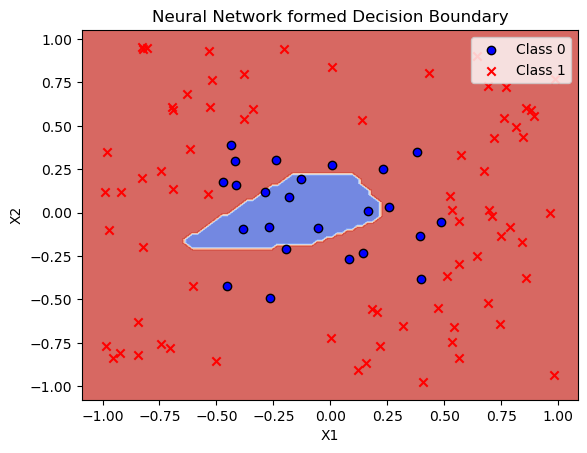

In [127]:
# Plot the neural network's decision boundary
plot_decision_boundary(nn_model_square, X_square, y_square, title="Neural Network formed Decision Boundary")

# For Live Demo Purpose

In [ ]:
pip install plotly

# 3D Plots for Data with different decision boundaries

In [68]:
fig = go.Figure()

# Add blue class points
fig.add_trace(go.Scatter3d(
    x=X_lin[y_nn_pred_lin == 0][:, 0],
    y=X_lin[y_nn_pred_lin == 0][:, 1],
    z=Z_lin[y_nn_pred_lin == 0],
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Class Blue (0)'
))

# Add red class points
fig.add_trace(go.Scatter3d(
    x=X_lin[y_nn_pred_lin == 1][:, 0],
    y=X_lin[y_nn_pred_lin == 1][:, 1],
    z=Z_lin[y_nn_pred_lin == 1],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Class Red (1)'
))

# Set plot layout
fig.update_layout(
    scene=dict(
        xaxis_title='X1',
        yaxis_title='X2',
        zaxis_title='Feature Z (Derived from X1)',
        camera=dict(
            eye=dict(x=0, y=2.5, z=0.0)  # Initial camera position to view from the X-Y plane
        )
    ),
    title='3D Plot of Data with Linear Decision Boundary Parallel to X2'
)

fig.update_layout(scene_dragmode='orbit')  # Lock to only horizontal rotation (orbit mode)
fig.show()

In [67]:
fig = go.Figure()

# Add blue class points
fig.add_trace(go.Scatter3d(
    x=X_linear[y_nn_pred_linear == 0][:, 0],  # X1 for class 0
    y=X_linear[y_nn_pred_linear == 0][:, 1],  # X2 for class 0
    z=Z_linear[y_nn_pred_linear == 0],        # Z for class 0
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Class Blue (0)'
))

# Add red class points
fig.add_trace(go.Scatter3d(
    x=X_linear[y_nn_pred_linear == 1][:, 0],  # X1 for class 1
    y=X_linear[y_nn_pred_linear == 1][:, 1],  # X2 for class 1
    z=Z_linear[y_nn_pred_linear == 1],        # Z for class 1
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Class Red (1)'
))

# Set plot layout
fig.update_layout(
    scene=dict(
        xaxis_title='X1',
        yaxis_title='X2',
        zaxis_title='Feature Z (Derived from X1)',
        camera=dict(
            eye=dict(x=0, y=-2.5, z=0.5)  # Initial camera position to view from the X-Y plane
        )
    ),
    title='3D Plot of Data with Oblique Decision Boundary'
)

fig.update_layout(scene_dragmode='orbit')  # Lock to only horizontal rotation (orbit mode)
fig.show()

In [76]:
fig = go.Figure()

# Add blue class points
fig.add_trace(go.Scatter3d(
    x=X_circular[y_nn_pred_circular == 0][:, 0],  # X1 for class 0
    y=X_circular[y_nn_pred_circular == 0][:, 1],  # X2 for class 0
    z=Z_circular[y_nn_pred_circular == 0],        # Z for class 0
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Class Blue (0)'
))

# Add red class points
fig.add_trace(go.Scatter3d(
    x=X_circular[y_nn_pred_circular == 1][:, 0],  # X1 for class 1
    y=X_circular[y_nn_pred_circular == 1][:, 1],  # X2 for class 1
    z=Z_circular[y_nn_pred_circular == 1],        # Z for class 1
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Class Red (1)'
))

# Set plot layout
fig.update_layout(
    scene=dict(
        xaxis_title='X1',
        yaxis_title='X2',
        zaxis_title='Feature Z (Derived from X1)',
        camera=dict(
            eye=dict(x=0.5, y=1.5, z=0.8)  # Initial camera position to view from the X-Y plane
        )
    ),
    title='3D Plot of Data with Circular Decision Boundary'
)

fig.update_layout(scene_dragmode='orbit')
fig.show()

In [77]:
fig = go.Figure()

# Add blue class points
fig.add_trace(go.Scatter3d(
    x=X_ellipse[y_nn_pred_ellipse == 0][:, 0],  # X1 for class 0
    y=X_ellipse[y_nn_pred_ellipse == 0][:, 1],  # X2 for class 0
    z=Z_ellipse[y_nn_pred_ellipse == 0],        # Z for class 0
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Class Blue (0)'
))

# Add red class points
fig.add_trace(go.Scatter3d(
    x=X_ellipse[y_nn_pred_ellipse == 1][:, 0],  # X1 for class 1
    y=X_ellipse[y_nn_pred_ellipse == 1][:, 1],  # X2 for class 1
    z=Z_ellipse[y_nn_pred_ellipse == 1],        # Z for class 1
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Class Red (1)'
))

# Set plot layout
fig.update_layout(
    scene=dict(
        xaxis_title='X1',
        yaxis_title='X2',
        zaxis_title='Feature Z (Derived from X1)',
        camera=dict(
            eye=dict(x=0.5, y=1.5, z=0.8)
        )
    ),
    title='3D Plot of Data with Elliptical Decision Boundary'
)

fig.update_layout(scene_dragmode='orbit')
fig.show()

In [71]:
fig = go.Figure()

# Add blue class points
fig.add_trace(go.Scatter3d(
    x=X_square[y_nn_pred_square == 0][:, 0],  # X1 for class 0
    y=X_square[y_nn_pred_square == 0][:, 1],  # X2 for class 0
    z=Z_square[y_nn_pred_square == 0],        # Z for class 0
    mode='markers',
    marker=dict(size=5, color='blue'),
    name='Class Blue (0)'
))

# Add red class points
fig.add_trace(go.Scatter3d(
    x=X_square[y_nn_pred_square == 1][:, 0],  # X1 for class 1
    y=X_square[y_nn_pred_square == 1][:, 1],  # X2 for class 1
    z=Z_square[y_nn_pred_square == 1],        # Z for class 1
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Class Red (1)'
))

# Set plot layout
fig.update_layout(
    scene=dict(
        xaxis_title='X1',
        yaxis_title='X2',
        zaxis_title='Feature Z (Derived from X1)',
        camera=dict(
            eye=dict(x=0, y=-2.5, z=0.5)  # Initial camera position to view from the X-Y plane
        )
    ),
    title='3D Plot of Data with Square-shaped Decision Boundary'
)

fig.update_layout(scene_dragmode='orbit')
fig.show()